In [1]:
#importing necessary libraries
import yfinance as yf
import pandas as pd
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split

In [2]:
# getting the stock data stored in stock_data
stock_symbol = 'AAPL'
stock_data = yf.download(stock_symbol, start='2014-01-01', end='2024-01-01')

[*********************100%%**********************]  1 of 1 completed


In [3]:
stock_data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-01-02,19.845715,19.893929,19.715000,19.754642,17.273232,234684800
2014-01-03,19.745001,19.775000,19.301071,19.320715,16.893810,392467600
2014-01-06,19.194643,19.528570,19.057142,19.426071,16.985933,412610800
2014-01-07,19.440001,19.498571,19.211430,19.287144,16.864452,317209200
2014-01-08,19.243214,19.484285,19.238930,19.409286,16.971254,258529600


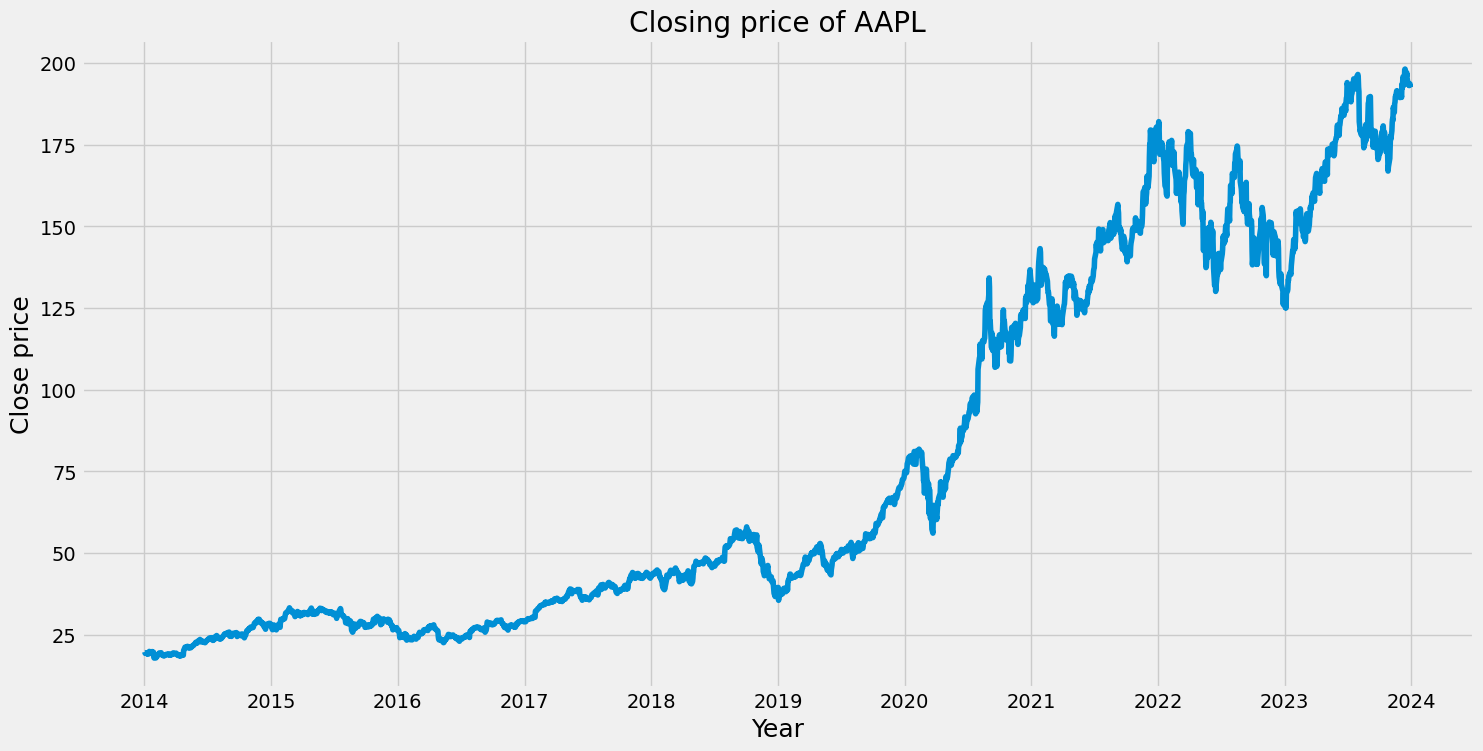

In [4]:
# Plotting Close price history of TCS
plt.style.use('fivethirtyeight')
plt.figure(figsize=(16,8))
plt.title('Closing price of AAPL')
plt.plot(stock_data['Close'])
plt.xlabel('Year', fontsize=18)
plt.ylabel('Close price', fontsize=18)
plt.show()

In [5]:
#create a dataframe with close column
data = stock_data.filter(['Close'])

# Normalize the data using min max normalization
data['Normalized_close'] = (data['Close'] - data['Close'].min()) / (data['Close'].max() - data['Close'].min())


In [6]:
data

,Close,Normalized_close
Date,,
2014-01-02,19.754642,0.010570
2014-01-03,19.320715,0.008163
2014-01-06,19.426071,0.008747
2014-01-07,19.287144,0.007977
2014-01-08,19.409286,0.008654
...,...,...
2023-12-22,193.600006,0.974981
2023-12-26,193.050003,0.971930
2023-12-27,193.149994,0.972484


In [7]:
# Split the data into training and testing sets
train_data, test_data = train_test_split(data, test_size=0.2, shuffle=False)

In [8]:
# Define the fuzzy variables
price = ctrl.Antecedent(np.arange(0, 1.1, 0.1), 'price')
prediction = ctrl.Consequent(np.arange(0, 1.1, 0.1), 'prediction')

# Auto membership function population
price.automf(3)
prediction.automf(3)

In [9]:
# Predict the train data
train_predicted_prices = []

for price_value in train_data['Normalized_close']:
    
    # Fuzzy inference
    price_level_poor = fuzz.interp_membership(price.universe, price['poor'].mf, price_value)
    price_level_average = fuzz.interp_membership(price.universe, price['average'].mf, price_value)
    price_level_good = fuzz.interp_membership(price.universe, price['good'].mf, price_value)
    
    # Apply the rules
    active_rule1 = np.fmin(price_level_poor, prediction['poor'].mf)
    active_rule2 = np.fmin(price_level_average, prediction['average'].mf)
    active_rule3 = np.fmin(price_level_good, prediction['good'].mf)
    
    aggregated = np.fmax(active_rule1, np.fmax(active_rule2, active_rule3))
    
    # Defuzzify
    prediction_value = fuzz.defuzz(prediction.universe, aggregated, 'centroid')
    
    train_predicted_prices.append(prediction_value)

# Denormalize the predicted prices
train_predicted_prices = np.array(train_predicted_prices) * (data['Close'].max() - data['Close'].min()) + data['Close'].min()

# Adding the predicted price to the dataframe
train_data['Predicted_Close'] = train_predicted_prices

In [10]:
train_data

,Close,Normalized_close,Predicted_Close
Date,,,
2014-01-02,19.754642,0.010570,51.906391
2014-01-03,19.320715,0.008163,51.018413
2014-01-06,19.426071,0.008747,51.235383
2014-01-07,19.287144,0.007977,50.949090
2014-01-08,19.409286,0.008654,51.200876
...,...,...,...
2021-12-21,172.990005,0.860646,132.377407
2021-12-22,175.639999,0.875347,134.761500
2021-12-23,176.279999,0.878898,135.358016


In [11]:
# Predict the test data
test_predicted_prices = []

for price_value in test_data['Normalized_close']:
    
    # Fuzzy inference
    price_level_poor = fuzz.interp_membership(price.universe, price['poor'].mf, price_value)
    price_level_average = fuzz.interp_membership(price.universe, price['average'].mf, price_value)
    price_level_good = fuzz.interp_membership(price.universe, price['good'].mf, price_value)
    
    # Apply the rules
    active_rule1 = np.fmin(price_level_poor, prediction['poor'].mf)
    active_rule2 = np.fmin(price_level_average, prediction['average'].mf)
    active_rule3 = np.fmin(price_level_good, prediction['good'].mf)
    
    aggregated = np.fmax(active_rule1, np.fmax(active_rule2, active_rule3))
    
    # Defuzzify
    prediction_value = fuzz.defuzz(prediction.universe, aggregated, 'centroid')
    
    test_predicted_prices.append(prediction_value)

# Denormalize the predicted prices
test_predicted_prices = np.array(test_predicted_prices) * (data['Close'].max() - data['Close'].min()) + data['Close'].min()



In [12]:
# Adding the predicted price to the test dataframe
test_data['Predicted_Close'] = test_predicted_prices

In [13]:
test_data

,Close,Normalized_close,Predicted_Close
Date,,,
2021-12-29,179.380005,0.896095,138.369839
2021-12-30,178.199997,0.889549,137.198787
2021-12-31,177.570007,0.886054,136.586143
2022-01-03,182.009995,0.910685,141.426798
2022-01-04,179.699997,0.897870,138.692820
...,...,...,...
2023-12-22,193.600006,0.974981,159.019551
2023-12-26,193.050003,0.971930,158.017511
2023-12-27,193.149994,0.972484,158.198193


In [14]:
# Calculate RMSE and MAPE for the test set
rmse = np.sqrt(mean_squared_error(test_data['Close'], test_data['Predicted_Close']))
print(f'Root mean squared error is : {rmse}')

mape = mean_absolute_percentage_error(test_data['Close'], test_data['Predicted_Close'])*100
print(f'Mean absolute percentage error is : {mape}')

Root mean squared error is : 35.68726219961218
Mean absolute percentage error is : 21.43425038881238


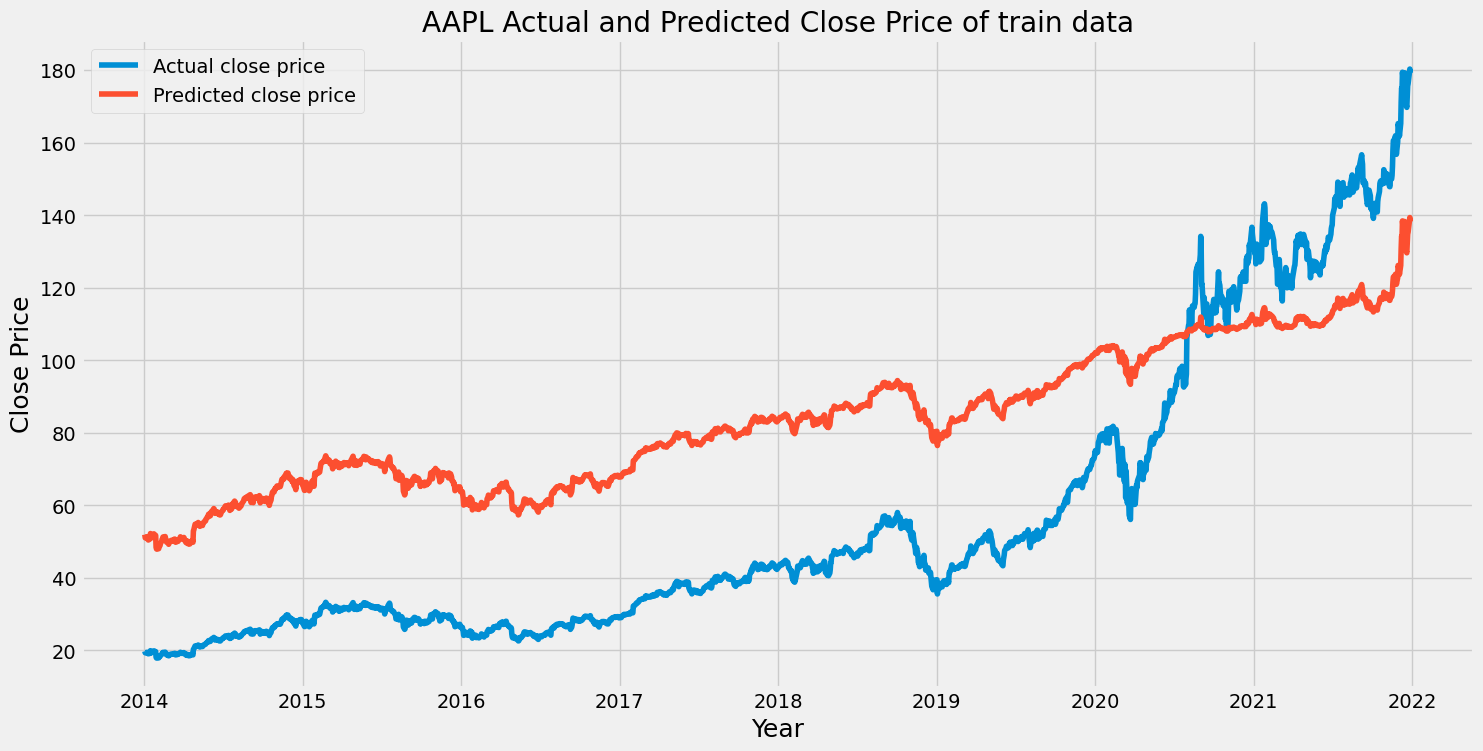

In [15]:
# graph of actual close vs predicted close of train data
plt.style.use('fivethirtyeight')
plt.figure(figsize=(16,8))
plt.title('AAPL Actual and Predicted Close Price of train data')
# Plot actual closing prices
plt.plot(train_data['Close'], label='Actual close price')
plt.plot(train_data['Predicted_Close'], label='Predicted close price')
# Adding labels and legend
plt.xlabel('Year', fontsize=18)
plt.ylabel('Close Price', fontsize=18)
plt.legend(fontsize=14)
plt.show()

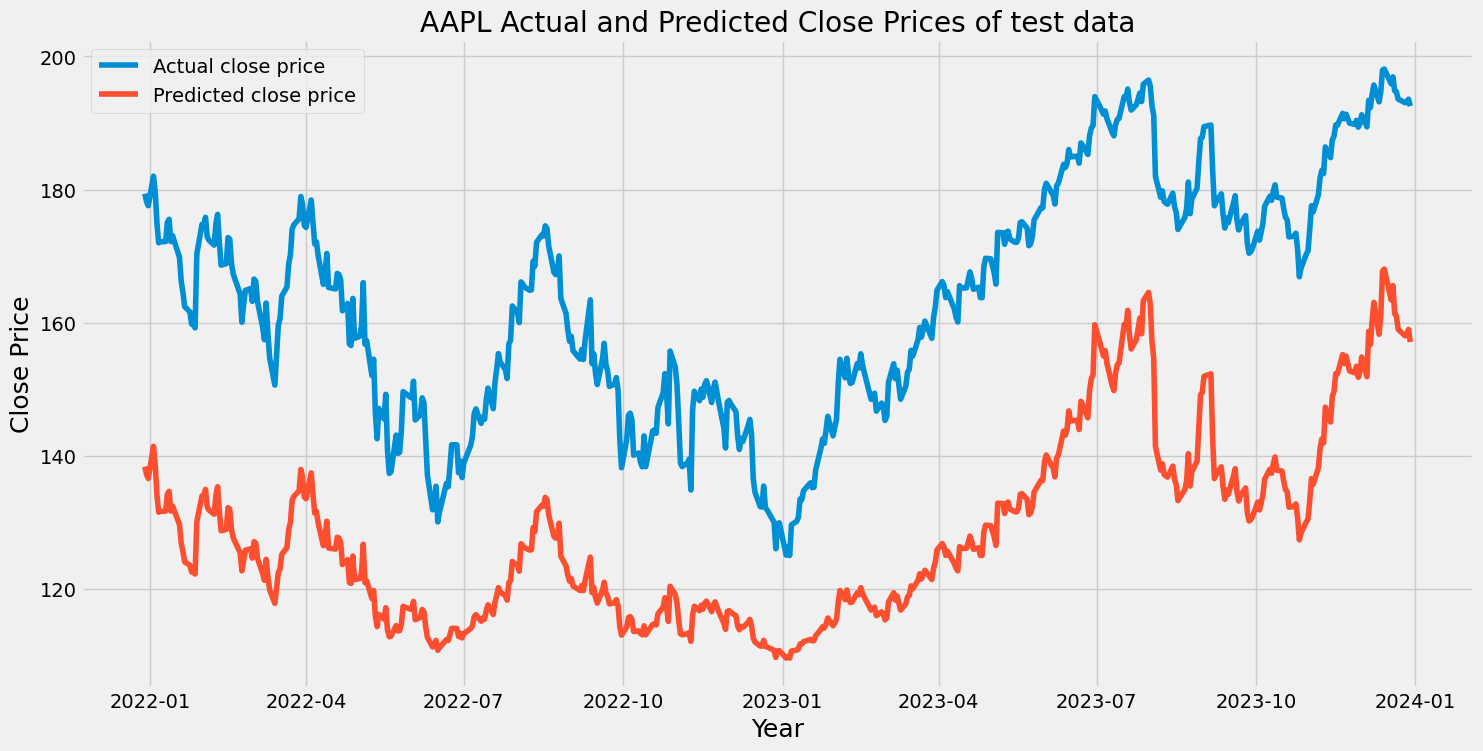

In [16]:
# graph of actual close vs predicted close of test data
plt.style.use('fivethirtyeight')
plt.figure(figsize=(16,8))
plt.title('AAPL Actual and Predicted Close Prices of test data')
# Plot actual closing prices
plt.plot(test_data['Close'], label='Actual close price')
plt.plot(test_data['Predicted_Close'], label='Predicted close price')
# Adding labels and legend
plt.xlabel('Year', fontsize=18)
plt.ylabel('Close Price', fontsize=18)
plt.legend(fontsize=14)
plt.show()

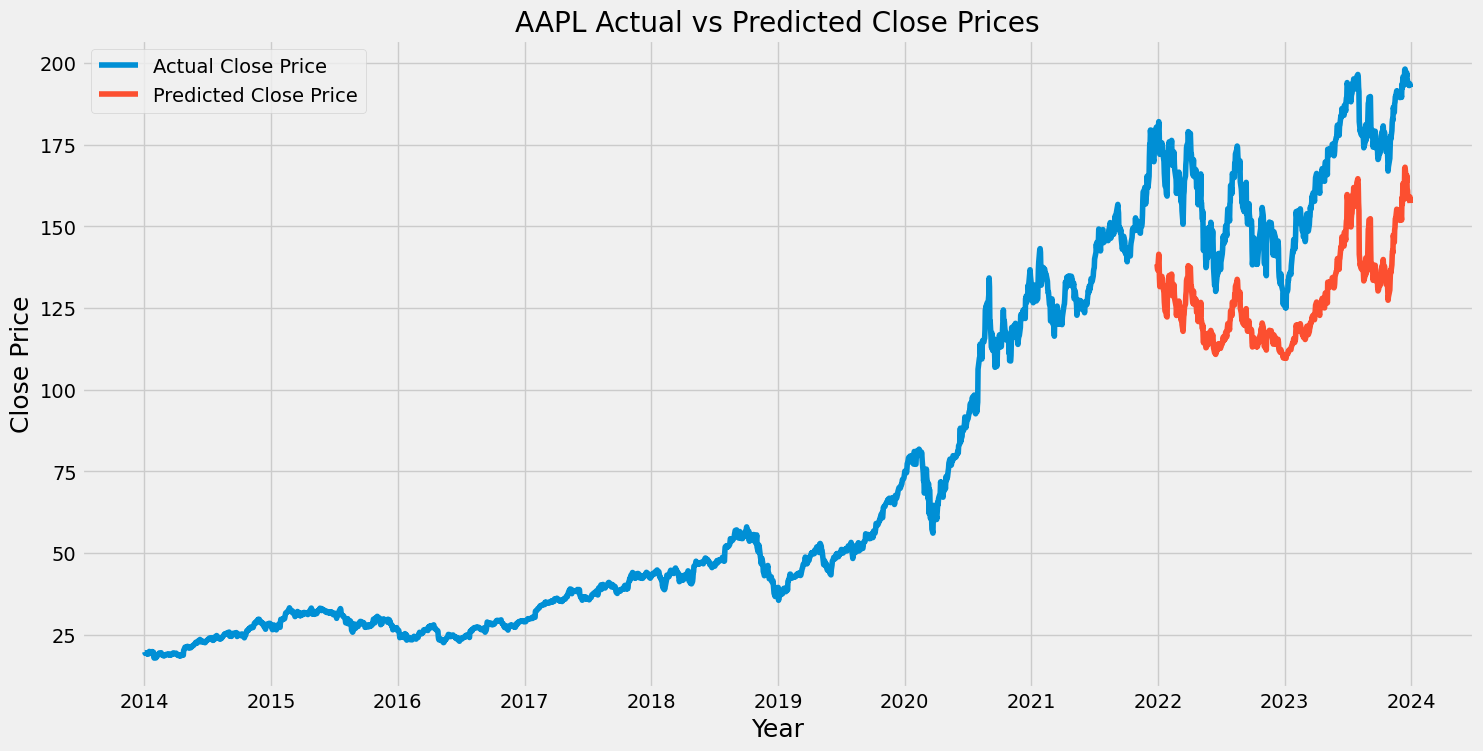

In [17]:
# Combine the actual close prices from train and test data for plotting
combined_actual = pd.concat([train_data['Close'], test_data['Close']])

plt.style.use('fivethirtyeight')
plt.figure(figsize=(16,8))
plt.title('AAPL Actual vs Predicted Close Prices')

# Plot actual closing prices for the combined data
plt.plot(combined_actual, label='Actual Close Price')

# Plot predicted closing prices for the test data
plt.plot(test_data.index, test_data['Predicted_Close'], label='Predicted Close Price')

# Adding labels and legend
plt.xlabel('Year', fontsize=18)
plt.ylabel('Close Price', fontsize=18)
plt.legend(fontsize=14)
plt.show()

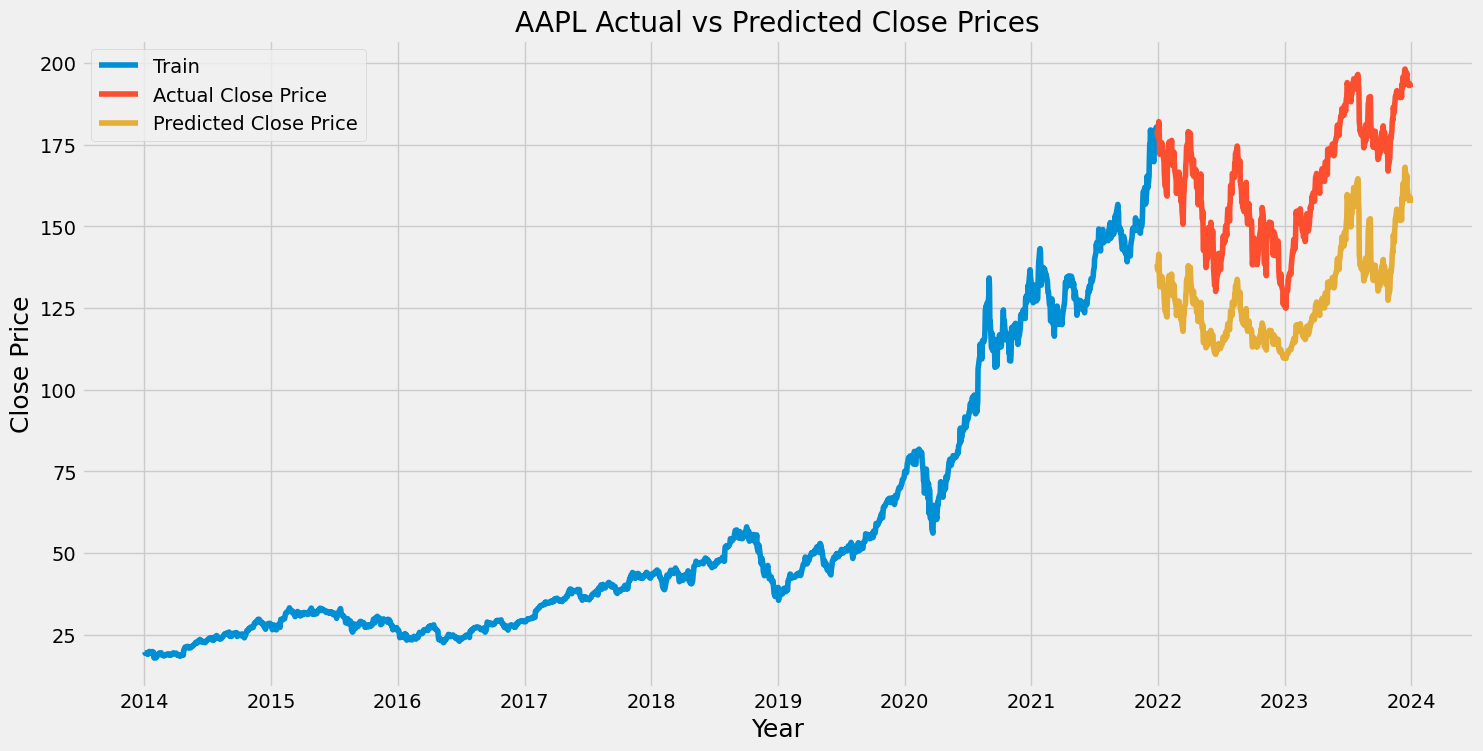

In [18]:
# Combine the actual close prices from train and test data for plotting
# combined_actual = pd.concat([train_data['Close'], test_data['Close']])

plt.style.use('fivethirtyeight')
plt.figure(figsize=(16,8))
plt.title('AAPL Actual vs Predicted Close Prices')

# Plot actual closing prices for the combined data
plt.plot(train_data['Close'], label='Train')

# Plot predicted closing prices for the test data
plt.plot(test_data.index, test_data['Close'], label='Actual Close Price')
plt.plot(test_data.index, test_data['Predicted_Close'], label='Predicted Close Price')

# Adding labels and legend
plt.xlabel('Year', fontsize=18)
plt.ylabel('Close Price', fontsize=18)
plt.legend(fontsize=14)
plt.show()